### Imports et initialisations

In [1]:
import numpy as np
# Pour l'échantillonnage aléatoire
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [2]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
clusters_dir = "clusters/1M_Lem_clusters/km_100/"

### Chargement des données en mémoire

In [120]:
clean_clusters, raw_clusters, two_dim_clusters = load_clusters(clusters_dir)

### Encodage du jeu de données

On charge le modèle depuis le disque

In [5]:
from gensim.models import KeyedVectors

In [8]:
encoding_model_file = "models/w2vec_model_d300_1M_Lem"

In [9]:
model = KeyedVectors.load(encoding_model_file)
dim = 300

In [108]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [121]:
%%time
#encodage des clusters
encoded_clusters = [np.array([encode(msg, model, dim) for msg in cluster]) for cluster in clean_clusters]

CPU times: user 18.3 s, sys: 192 µs, total: 18.3 s
Wall time: 18.4 s


### Visualisation du dataset

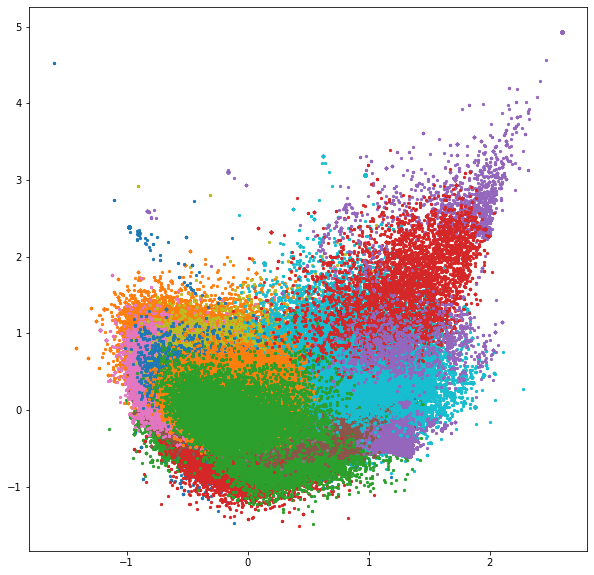

In [59]:
plot_clusters(two_dim_clusters)

### Kmeans

Pour mémoire : méthode de calcul du nombre idéal de clusters avec la méthode du coude (elbow method)
```python
sum_of_squared_dist = []
for k in range(1, 60):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)
    
plt.plot(range(1, 60), sum_of_squared_dist, 'bx-')
plt.show
```

In [43]:
n_clust = 10

#### Partitionnement de chaque cluster, analyse, impression des résultats et sauvegarde des sous-clusters sur le disque.
Pour que la sortie reste lisible, on n'affiche que les résultats pour les clusters potentiellement haineux (dont le pourcentage de messages contenant au moins un mot haineux est supérieur à 5%).

In [122]:
%%time

for i, (enc_cluster, clean_cluster, raw_cluster, two_dim_cluster) in enumerate(zip(encoded_clusters, clean_clusters, raw_clusters, two_dim_clusters)):
    init_globals(clean_cluster, raw_cluster, two_dim_cluster, clusters_dir + "_{}".format(i))
    km_model = KMeans(n_clusters=n_clust, random_state=0)
    kmeans = km_model.fit(enc_cluster)
    km_pred = kmeans.predict(enc_cluster)
    km_centers = [[r[0] for r in model.similar_by_vector(center)] for center in km_model.cluster_centers_]
    #parse_result(km_pred, 'km_{}'.format(n_clust), km_centers)
    #show_hate_clusters(km_pred, km_centers)
    wlists, mlists, cmlists, e2dmlists, mfw, hkw, clust_n_msg = parse(km_pred)
    cluster_number_printed = False
    for j in range(len(clust_n_msg)):
        if (hkw[j][1] > 5):
            if not cluster_number_printed:
                cluster_number_printed = True
                print("Cluster {}:".format(i))
            print("Sous-cluster {} : {} messages".format(j, clust_n_msg[j]))
            print("{} messages contiennent un mot-clé haineux (soit {:.2f}%)".format(hkw[j][0], hkw[j][1]))
            print("Les {} mots les plus fréquents :".format(len(mfw[j])), end=' ')
            for word in mfw[j]:
                print(word, end=' ')
            print("\nLes mots les plus proches du centre :", end = ' ')
            for w in km_centers[j]:
                print(w, end=' ')
            print('\n')
            save_cluster_raw_msg(mlists[j], clusters_dir + "_cluster_{}.{}_raw_msg_{:.2f}pch".format(i,j, hkw[j][1]))
            with open(clusters_dir + "_subclusters_info.txt", "a") as f:
                f.write("Cluster {}, sous-cluster {} : {} messages\n".format(i, j, clust_n_msg[j]))
                f.write("{} messages contiennent un mot-clé haineux (soit {:.2f}%)\n".format(hkw[j][0], hkw[j][1]))
                f.write("Les {} mots les plus fréquents : ".format(len(mfw[j])))
                for word in mfw[j]:
                    f.write(word)
                f.write("\nLes mots les plus proches du centre : ")
                for w in km_centers[j]:
                    f.write(w)
                f.write('\n\n')
    if cluster_number_printed:
        print()

Cluster 30:
Sous-cluster 0 : 329 messages
20 messages contiennent un mot-clé haineux (soit 6.08%)
Les 20 mots les plus fréquents : twitter niafou merd wallah fou pitier / beur damien ramener live ptdr #spaceafroo jsuis rebeux pq jsp rieu jvai 3h 
Les mots les plus proches du centre : rebeux bassem? #spaceafroo #diamantspac bassem spac niafou badr sayez beur 

Sous-cluster 4 : 425 messages
178 messages contiennent un mot-clé haineux (soit 41.88%)
Les 20 mots les plus fréquents : communauté musulman homme / réseau? être noir. que arabe, de insult dormir jsuis arrêter vient réseau vous ... noir? sale 
Les mots les plus proches du centre : maghrébin? arabe? #diamantspac maghrebin métissage babidi maghrebine noirs qu’noir bassem? 


Cluster 45:
Sous-cluster 8 : 48 messages
38 messages contiennent un mot-clé haineux (soit 79.17%)
Les 20 mots les plus fréquents : fils sale mère fil espèce mort gueule frr normal dégoûte traiter geul pd connaître maelle réel suceur psg me report? 
Les mots les 

<timed exec>:4: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.


Cluster 84:
Sous-cluster 6 : 225 messages
12 messages contiennent un mot-clé haineux (soit 5.33%)
Les 20 mots les plus fréquents : only tcg celebration store #ad buy 19.99 pokemon locations vary box #pokemongofriend #pokemongo i diamond delux pin #pokemongofriendcod #pokemongoraid brillier 
Les mots les plus proches du centre : let'be go! unite diamond pearl celebration friend yourself pokémon pokémon, 


Cluster 97:
Sous-cluster 9 : 119 messages
12 messages contiennent un mot-clé haineux (soit 10.08%)
Les 20 mots les plus fréquents : pute niqu pèr arrière mere jure fou pue envie pote bandit accord mental parent époque paternel wsh âge insulter choquer 
Les mots les plus proches du centre : grand qu’bais niquez daron, baisez cousin, tapin foutoir quesqu nique 


CPU times: user 26min 6s, sys: 9min 16s, total: 35min 22s
Wall time: 4min 50s
